### Denoising Autoencoders And Where To Find Them 



My test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [0]:
import numpy as np
import os
from scipy.misc import imread,imresize
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):#sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s"%attrs_name)
        print("done")

    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    df_attrs.imagenum = df_attrs.imagenum.astype(np.int64)


    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)


    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: imresize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs
    

In [47]:
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


X shape: (13143, 38, 38, 3)
attr shape: (13143, 73)


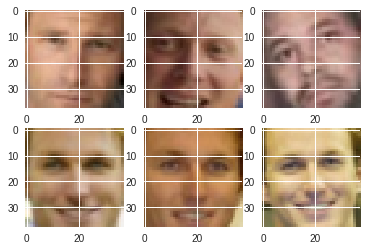

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture





<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



In [6]:
import tensorflow as tf
import keras, keras.layers as L
s = keras.backend.get_session()

Using TensorFlow backend.


## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $




In [0]:
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model

In [0]:
encoder,decoder = build_pca_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [7]:
autoencoder.fit(x=X_train,y=X_train,epochs=32,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/32
11828/11828 [==============================] - 3s 220us/step - loss: 0.0255 - val_loss: 0.0151
Epoch 2/32
11828/11828 [==============================] - 2s 155us/step - loss: 0.0130 - val_loss: 0.0118
Epoch 3/32
11828/11828 [==============================] - 2s 152us/step - loss: 0.0107 - val_loss: 0.0102
Epoch 4/32
11828/11828 [==============================] - 2s 155us/step - loss: 0.0090 - val_loss: 0.0085
Epoch 5/32
11828/11828 [==============================] - 2s 172us/step - loss: 0.0080 - val_loss: 0.0077
Epoch 6/32
11828/11828 [==============================] - 2s 202us/step - loss: 0.0071 - val_loss: 0.0069
Epoch 7/32
11828/11828 [==============================] - 2s 210us/step - loss: 0.0066 - val_loss: 0.0064
Epoch 8/32
11828/11828 [==============================] - 3s 215us/step - loss: 0.0061 - val_loss: 0.0061
Epoch 9/32
11828/11828 [==============================] - 3s 214us/step - loss: 0.0059 - val_loss: 0.00

In [0]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()


Final MSE: 0.005591287107132517


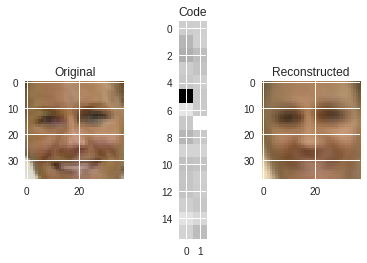

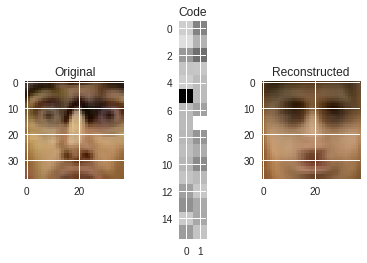

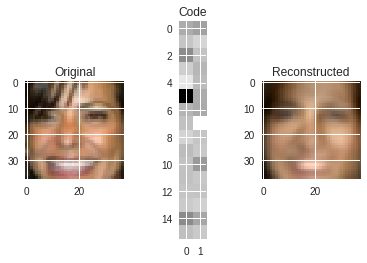

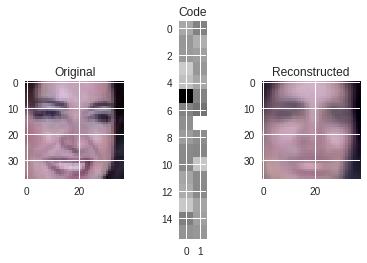

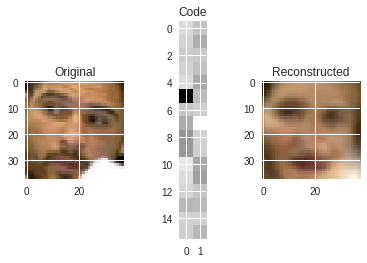

In [9]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("Final MSE:",score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [0]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(2000, activation='relu'))
    encoder.add(L.Dense(1000, activation='relu'))
    encoder.add(L.Dense(512, activation='relu'))
    encoder.add(L.Dense(code_size))

    
    
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(512, activation='relu'))
    decoder.add(L.Dense(1000, activation='relu'))
    decoder.add(L.Dense(2000, activation='relu'))
    decoder.add(L.Dense(H*W*C))  
    decoder.add(L.Reshape([H, W, C])) 

    
    return encoder,decoder

In [0]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile(loss='mse',
                   optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False))

Training may take some 20 minutes.

In [0]:
autoencoder.fit(x=X_train,y=X_train,epochs=50,
                validation_data=[X_test,X_test])

Final MSE: 0.004961424289774079


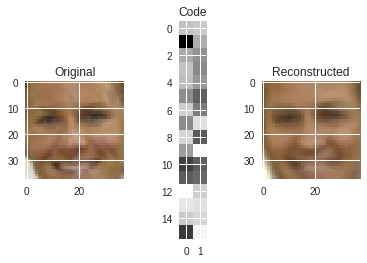

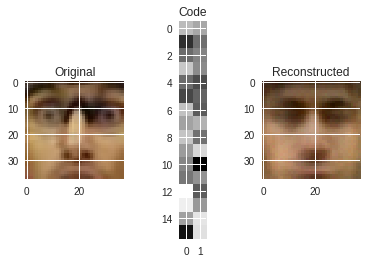

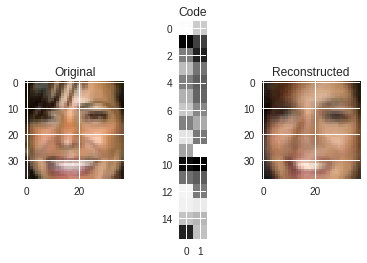

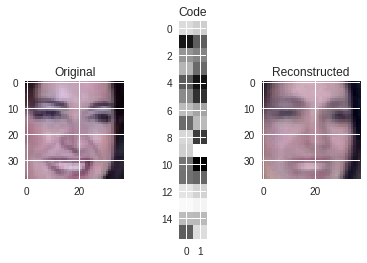

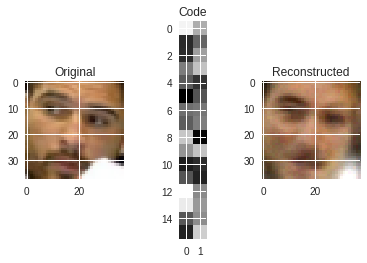

In [49]:
reconstruction_mse = autoencoder.evaluate(X_test,X_test,verbose=0)
assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
assert len(encoder.output_shape)==2 and encoder.output_shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [0]:
def apply_gaussian_noise(matrix,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    _, h, w, _ = matrix.shape
    noisy_image = np.zeros(matrix.shape)
    noise = np.random.normal(loc=0, scale=sigma, size=[h, w])
    noisy_image[:,:,:,0] = matrix[:,:,:,0] + noise
    noisy_image[:,:,:,1] = matrix[:,:,:,1] + noise
    noisy_image[:,:,:,2] = matrix[:,:,:,2] + noise
        
    return noisy_image
    
    

In [0]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

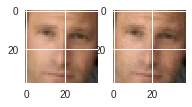

In [127]:
plt.subplot(1,4,1)
plt.imshow(X[0])
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0])
# plt.subplot(1,4,3)
# plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0])
# # plt.subplot(1,4,4)
# # plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0])
plt.show()

In [0]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp, reconstruction)
autoencoder.compile(loss='mse',
                    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False))

In [67]:
for i in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%i)
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    autoencoder.fit(x=X_train_noise,y=X_train,epochs=1,
                    validation_data=[X_test_noise,X_test])

Epoch 0/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 15s 1ms/step - loss: 0.0217 - val_loss: 0.0115
Epoch 1/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 2/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 3/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 4/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 5/50, Gen

__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

In [0]:
denoising_mse = autoencoder.evaluate(apply_gaussian_noise(X_test),X_test,verbose=0)
print("Final MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

In [0]:
encoder.save("./encoder.h5")
decoder.save("./decoder.h5")

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [76]:
images.shape

(11828, 38, 38, 3)

In [86]:
images = X_train
encoder_model = keras.models.load_model('encoder.h5')
codes = encoder_model.predict(images)
assert len(codes) == len(images)

/usr/local/lib/python3.6/dist-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [87]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/approximate.py:220: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [0]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [0]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

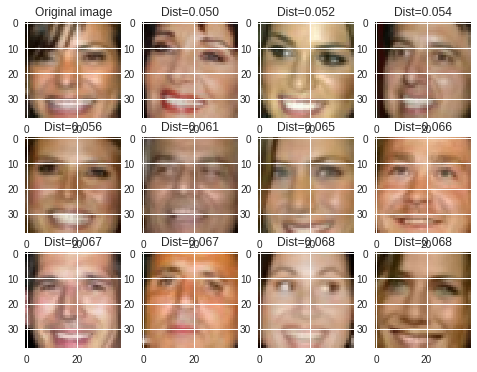

In [90]:
#smiles
show_similar(X_test[2])

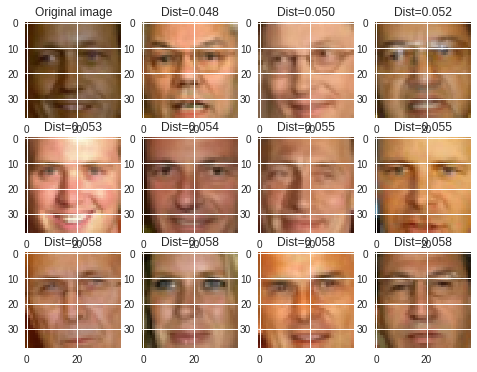

In [91]:
#ethnicity
show_similar(X_test[500])

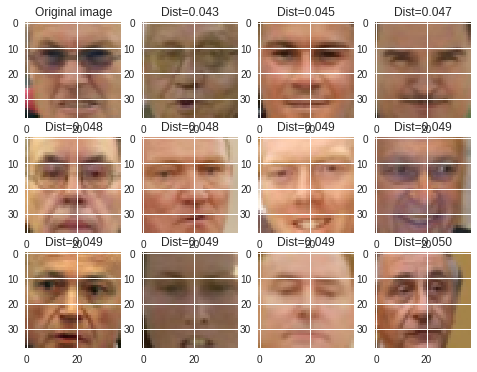

In [92]:
#glasses
show_similar(X_test[66])